<a href="https://colab.research.google.com/github/yashveersinghsohi/Kaggle_Competitions/blob/HousePrice/House%20Prices/Submissions/Sub%204%20-%20Boosting%20and%20Stacking/Sub_4_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second Commit from Colab

# Importing Required Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor

#  Reading Data

In [29]:
# url = "https://raw.githubusercontent.com/yashveersinghsohi/Kaggle_Competitions/HousePrice/House%20Prices/Submissions/Data/"

# train_df = pd.read_csv(url + "train.csv")
# test_df = pd.read_csv(url + "test.csv")

# train_features_df = pd.read_csv(url + "train_features_df.csv")
# test_features_df = pd.read_csv(url + "test_features_df.csv")

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_features_df = pd.read_csv("train_features_df.csv")
test_features_df = pd.read_csv("test_features_df.csv")

In [4]:
train_features_df.head()

,OverallQual,ExterQual,Foundation,BsmtQual,KitchenQual,FireplaceQu,GarageFinish,YearDiff,YearRemodAdd,1stFlrSF,GrLivArea,FullBath,GarageCars,Neighborhood,MasVnrType,HeatingQC,Fireplaces,MasVnrArea,GarageYrBlt,HouseStyle,Exterior1st,Exterior2nd,BsmtExposure,BsmtFinType1,GarageType,OverallCond,LotArea,BsmtFinSF1,LotFrontage,2ndFlrSF,SalePrice,no_garage,is_BsmtFinSF1_0,is_2ndFlrSF_0
0,7,2,6,3,2,1,2,2.472136,87.509776,6.752270,7.444249,2,2,16,2,4,0,196.0,2003,6,11,13,1,6,5,8,9.041922,706,4.174387,854,208500,0,0,0
1,6,1,3,3,1,3,2,9.135529,86.904443,7.140453,7.140453,2,2,19,1,4,1,0.0,1976,4,6,4,4,4,5,4,9.169518,978,4.382027,0,181500,0,0,1
2,7,2,6,3,2,3,2,3.291503,87.487429,6.824374,7.487734,2,2,16,2,4,1,162.0,2001,6,11,13,2,6,5,8,9.328123,486,4.219508,866,223500,0,0,0
3,7,1,2,2,2,4,1,17.078784,86.769364,6.867974,7.448334,1,3,18,1,3,1,0.0,1998,6,5,3,1,4,2,8,9.164296,216,4.094345,756,140000,0,0,0
4,8,2,6,3,2,3,2,3.656854,87.442719,7.043160,7.695303,2,3,23,2,4,1,350.0,2000,6,11,13,3,6,5,8,9.565214,655,4.430817,1053,250000,0,0,0


In [5]:
test_features_df.head()

,OverallQual,ExterQual,Foundation,BsmtQual,KitchenQual,FireplaceQu,GarageFinish,YearDiff,YearRemodAdd,1stFlrSF,GrLivArea,FullBath,GarageCars,Neighborhood,MasVnrType,HeatingQC,Fireplaces,MasVnrArea,GarageYrBlt,HouseStyle,Exterior1st,Exterior2nd,BsmtExposure,BsmtFinType1,GarageType,OverallCond,LotArea,BsmtFinSF1,LotFrontage,2ndFlrSF,no_garage,is_BsmtFinSF1_0,is_2ndFlrSF_0
0,5,1,3,2,1,1,1,12.000000,86.566359,6.797940,6.797940,1,1,9,1,2,0,0.0,7.581210,4,11,13,1,3,5,6,9.360655,468.0,4.382027,0,0,0,1
1,6,1,3,2,2,1,1,12.422205,86.498588,7.192182,7.192182,1,1,9,2,2,0,108.0,7.579679,4,5,2,1,4,5,6,9.565704,923.0,4.394449,0,0,0,1
2,5,1,6,3,1,3,3,5.211103,87.397987,6.833032,7.395722,2,2,13,1,3,1,0.0,7.599401,6,11,13,1,6,5,5,9.534595,791.0,4.304065,701,0,0,0
3,6,1,6,2,2,4,3,4.928203,87.397987,6.830874,7.380256,2,2,13,2,4,1,20.0,7.599902,6,11,13,1,6,5,6,9.208138,602.0,4.356709,678,0,0,0
4,8,2,6,3,2,1,2,6.485281,87.263654,7.154615,7.154615,2,2,22,1,4,0,0.0,7.596894,4,8,8,1,4,5,5,8.518193,263.0,3.761200,0,0,0,1


# Train Test Split

In [6]:
def split_data(df, test_size = 0.2, random_state = 42):
    X, y = df.drop(["SalePrice"], axis = 1), df["SalePrice"]
    return train_test_split(X, y, test_size = test_size, random_state = random_state)

# Adaboost Regressor

## Base AdaBoost Regressor

**Model**

In [7]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
ada = AdaBoostRegressor(random_state = 42).fit(X_train, np.log(y_train))
ada_preds = np.exp(ada.predict(X_test))

**RMSLE**

In [8]:
np.sqrt(mean_squared_log_error(y_true = y_test, y_pred  = ada_preds))

0.17253553560633222

## GridSearchCV

**Defining Grid**

In [9]:
base_ada = AdaBoostRegressor(random_state = 42)
params = {
    "learning_rate": [0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    "n_estimators": [50, 75, 100, 150, 200, 300, 500, 1000],
    "loss": ["linear", "square", "exponential"]
}

grid = GridSearchCV(estimator = base_ada, 
                    param_grid = params, 
                    scoring = "neg_mean_squared_log_error", 
                    cv = 3, 
                    verbose = 3, 
                    n_jobs = -1)

**Fitting Grid**

In [10]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
ada_grid = grid.fit(X_train, np.log(y_train))

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:  5.0min finished


**Best AdaBoost from GridSearchCV**

In [11]:
np.sqrt(mean_squared_log_error(y_true = y_test, 
                               y_pred = np.exp(ada_grid.best_estimator_.predict(X_test))))

0.17287705642165474

# GBM Regressor

## Base GBM Regressor

In [12]:
X_train, X_test, y_train, y_test = split_data(train_features_df)
gbm = GradientBoostingRegressor(random_state = 42).fit(X_train, np.log(y_train))
gbm_preds = np.exp(gbm.predict(X_test))

In [13]:
np.sqrt(mean_squared_log_error(y_true = y_test, 
                               y_pred = gbm_preds))

0.13628312366698758

## GridSearchCV

### Preliminary Optimization of Boosting parameters

- **learning_rate**
- **n_estimators**

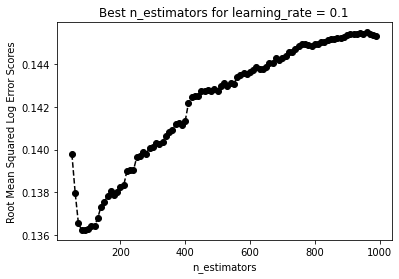

In [47]:
ns = np.arange(50, 1000, 10)
gbm_scores = []

X_train, X_test, y_train, y_test = split_data(train_features_df)
for n in ns:
  gbm = GradientBoostingRegressor(learning_rate = 0.1, 
                                  n_estimators = n, 
                                  random_state = 42).fit(X_train, np.log(y_train))
  
  gbm_preds = np.exp(gbm.predict(X_test))
  gbm_rmsle = np.sqrt(mean_squared_log_error(y_true = y_test, y_pred = gbm_preds))
  gbm_scores.append(gbm_rmsle)

fig, ax = plt.subplots()
ax.plot(ns, gbm_scores, marker = "o", linestyle = "--", color = "k")
ax.set(xlabel = "n_estimators", 
       ylabel = "Root Mean Squared Log Error Scores", 
       title = "Best n_estimators for learning_rate = 0.1")
plt.show()

RESULTS
Number of estimators:  80
Learning Rate:  0.1
Root Mean Squarred Log Error:  0.1362312022198972


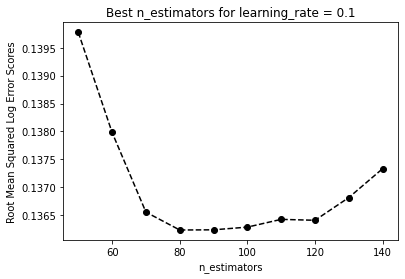

In [55]:
min_idx = np.argmin(np.array(gbm_scores))
print("RESULTS")
print("Number of estimators: ", ns[min_idx])
print("Learning Rate: ", 0.1)
print("Root Mean Squarred Log Error: ", gbm_scores[min_idx])

fig, ax = plt.subplots()
ax.plot(ns[:10], gbm_scores[:10], marker = "o", linestyle = "--", color = "k")
ax.set(xlabel = "n_estimators", 
       ylabel = "Root Mean Squared Log Error Scores", 
       title = "Best n_estimators for learning_rate = 0.1")
plt.show()

### Optimizing Tree Based Parameters

- **subsample**
- **min_samples_split**
- **min_samples_leaf**
- **max_depth**
- **max_features**